# Saturation- Geometry Ambiguity
PR vs. SDD for a subgroup of depths and a subgroup of saturations showing that they intersect. Proving that from a single SDD, it is impossible to recover saturation since multiple pairs can create the same value!

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import pandas as pd
from inverse_modelling_tfo.features.build_features import TwoColumnOperationFeatureBuilder

# Load in pre-saved data
from pathlib import Path
import json 

## Files
# "pulsation_ratio_interp_sd2_3wv.pkl" - stable derivatives with derivative pinning
# "pulsation_ratio_interp_sd2_3wv(alt).pkl" - stable derivatives without derivative pinning 
pr_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "pulsation_ratio_interp_sd2_3wv.pkl"
pr_data = pd.read_pickle(pr_data_path)
pr_config_path = pr_data_path.with_suffix('.json')
with open(pr_config_path, 'r') as file:
    pr_config = json.load(file)
pr_columns = pr_config['features']
labels = pr_config['labels']

# One of the saturation value has a silly issue with fp accuracy
pr_data["Fetal Saturation"] = pr_data["Fetal Saturation"].round(2)


# ## Create I2/I1 data
# # Get I2/I1 column names
# i1_wv2 = pr_columns[:len(pr_columns)//4]
# i1_wv1 = pr_columns[len(pr_columns)//4:2*len(pr_columns)//4]
# i2_wv2 = pr_columns[2*len(pr_columns)//4:3*len(pr_columns)//4]
# i2_wv1 = pr_columns[3*len(pr_columns)//4:]

# # Create the feature builders
# fb1 = TwoColumnOperationFeatureBuilder(i2_wv1, i1_wv1, '/', False, pr_columns, labels)
# fb2 = TwoColumnOperationFeatureBuilder.from_chain(fb1, i2_wv2, i1_wv2, '/', False)

# Transform the data
# pr_data = fb2(pr_data)

# new_features = fb2.get_feature_names()

In [16]:
fetal_sat_select = [0.2, 0.4, 0.6]
chosen_maternal_wall_thickness = [4.0, 5.0, 6.0]
# Filter the data
pr_data = pr_data[
    (pr_data["Maternal Wall Thickness"].isin(chosen_maternal_wall_thickness)) &
    (pr_data["Maternal Hb Concentration"] == 12.0) &
    (pr_data["Fetal Hb Concentration 2"] == 12.0) &
    (pr_data["Fetal Saturation"].isin(fetal_sat_select)) &
    (pr_data["Maternal Saturation"] == 1.0)
]

In [17]:
# Choose a Wavelength
features_to_drop = [col for col in pr_columns if ('_1.0_' in col) or ('_3.0_' in col)]  # Plots 850nm
pr_data = pr_data.drop(columns=features_to_drop)

# Convert Names to SDD
tmp_columns = ['Maternal Wall Thickness', 'Maternal Hb Concentration',
       'Maternal Saturation', 'Fetal Saturation', 'FconcCenters',
       'Fetal Hb Concentration 1', 'Fetal Hb Concentration 2']
def convert_column_name(name: str):
    if name in tmp_columns:
        return name
    else:
        return name.split('_')[0]
    
pr_data = pr_data.rename(columns=convert_column_name)

In [18]:
# Wide to Tall
# Convert the columns name with numbers to a new column named SDD
pr_data1 = pr_data.melt(id_vars=tmp_columns, var_name='SDD(mm)', value_name='PR')
pr_data1['SDD(mm)'] = pr_data1['SDD(mm)'].astype(int)
pr_data1["Fetal Depth (mm)"] = pr_data1["Maternal Wall Thickness"] + 6.0


In [19]:
pr_data1.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Saturation,FconcCenters,Fetal Hb Concentration 1,Fetal Hb Concentration 2,SDD(mm),PR,Fetal Depth (mm)
0,4.0,12.0,1.0,0.2,2.0,11.7,12.0,10,1.002440,10.0
1,4.0,12.0,1.0,0.4,2.0,11.7,12.0,10,1.002462,10.0
2,4.0,12.0,1.0,0.6,2.0,11.7,12.0,10,1.002459,10.0
3,5.0,12.0,1.0,0.2,2.0,11.7,12.0,10,1.001618,11.0
4,5.0,12.0,1.0,0.4,2.0,11.7,12.0,10,1.001620,11.0


In [20]:
## Silly things to do before plotting
# Convert Fetal Saturation To Percentage 
pr_data1 = pr_data1.rename(columns={'Fetal Saturation': r'Fetal Saturation (%)'})
pr_data1['Fetal Saturation (%)'] = (pr_data1[r'Fetal Saturation (%)'] * 100).round(0)

In [21]:
# Plot Defaults
# Increase the xlabel and ylabel font size
plt.rcParams.update({'axes.labelsize': 'large'})

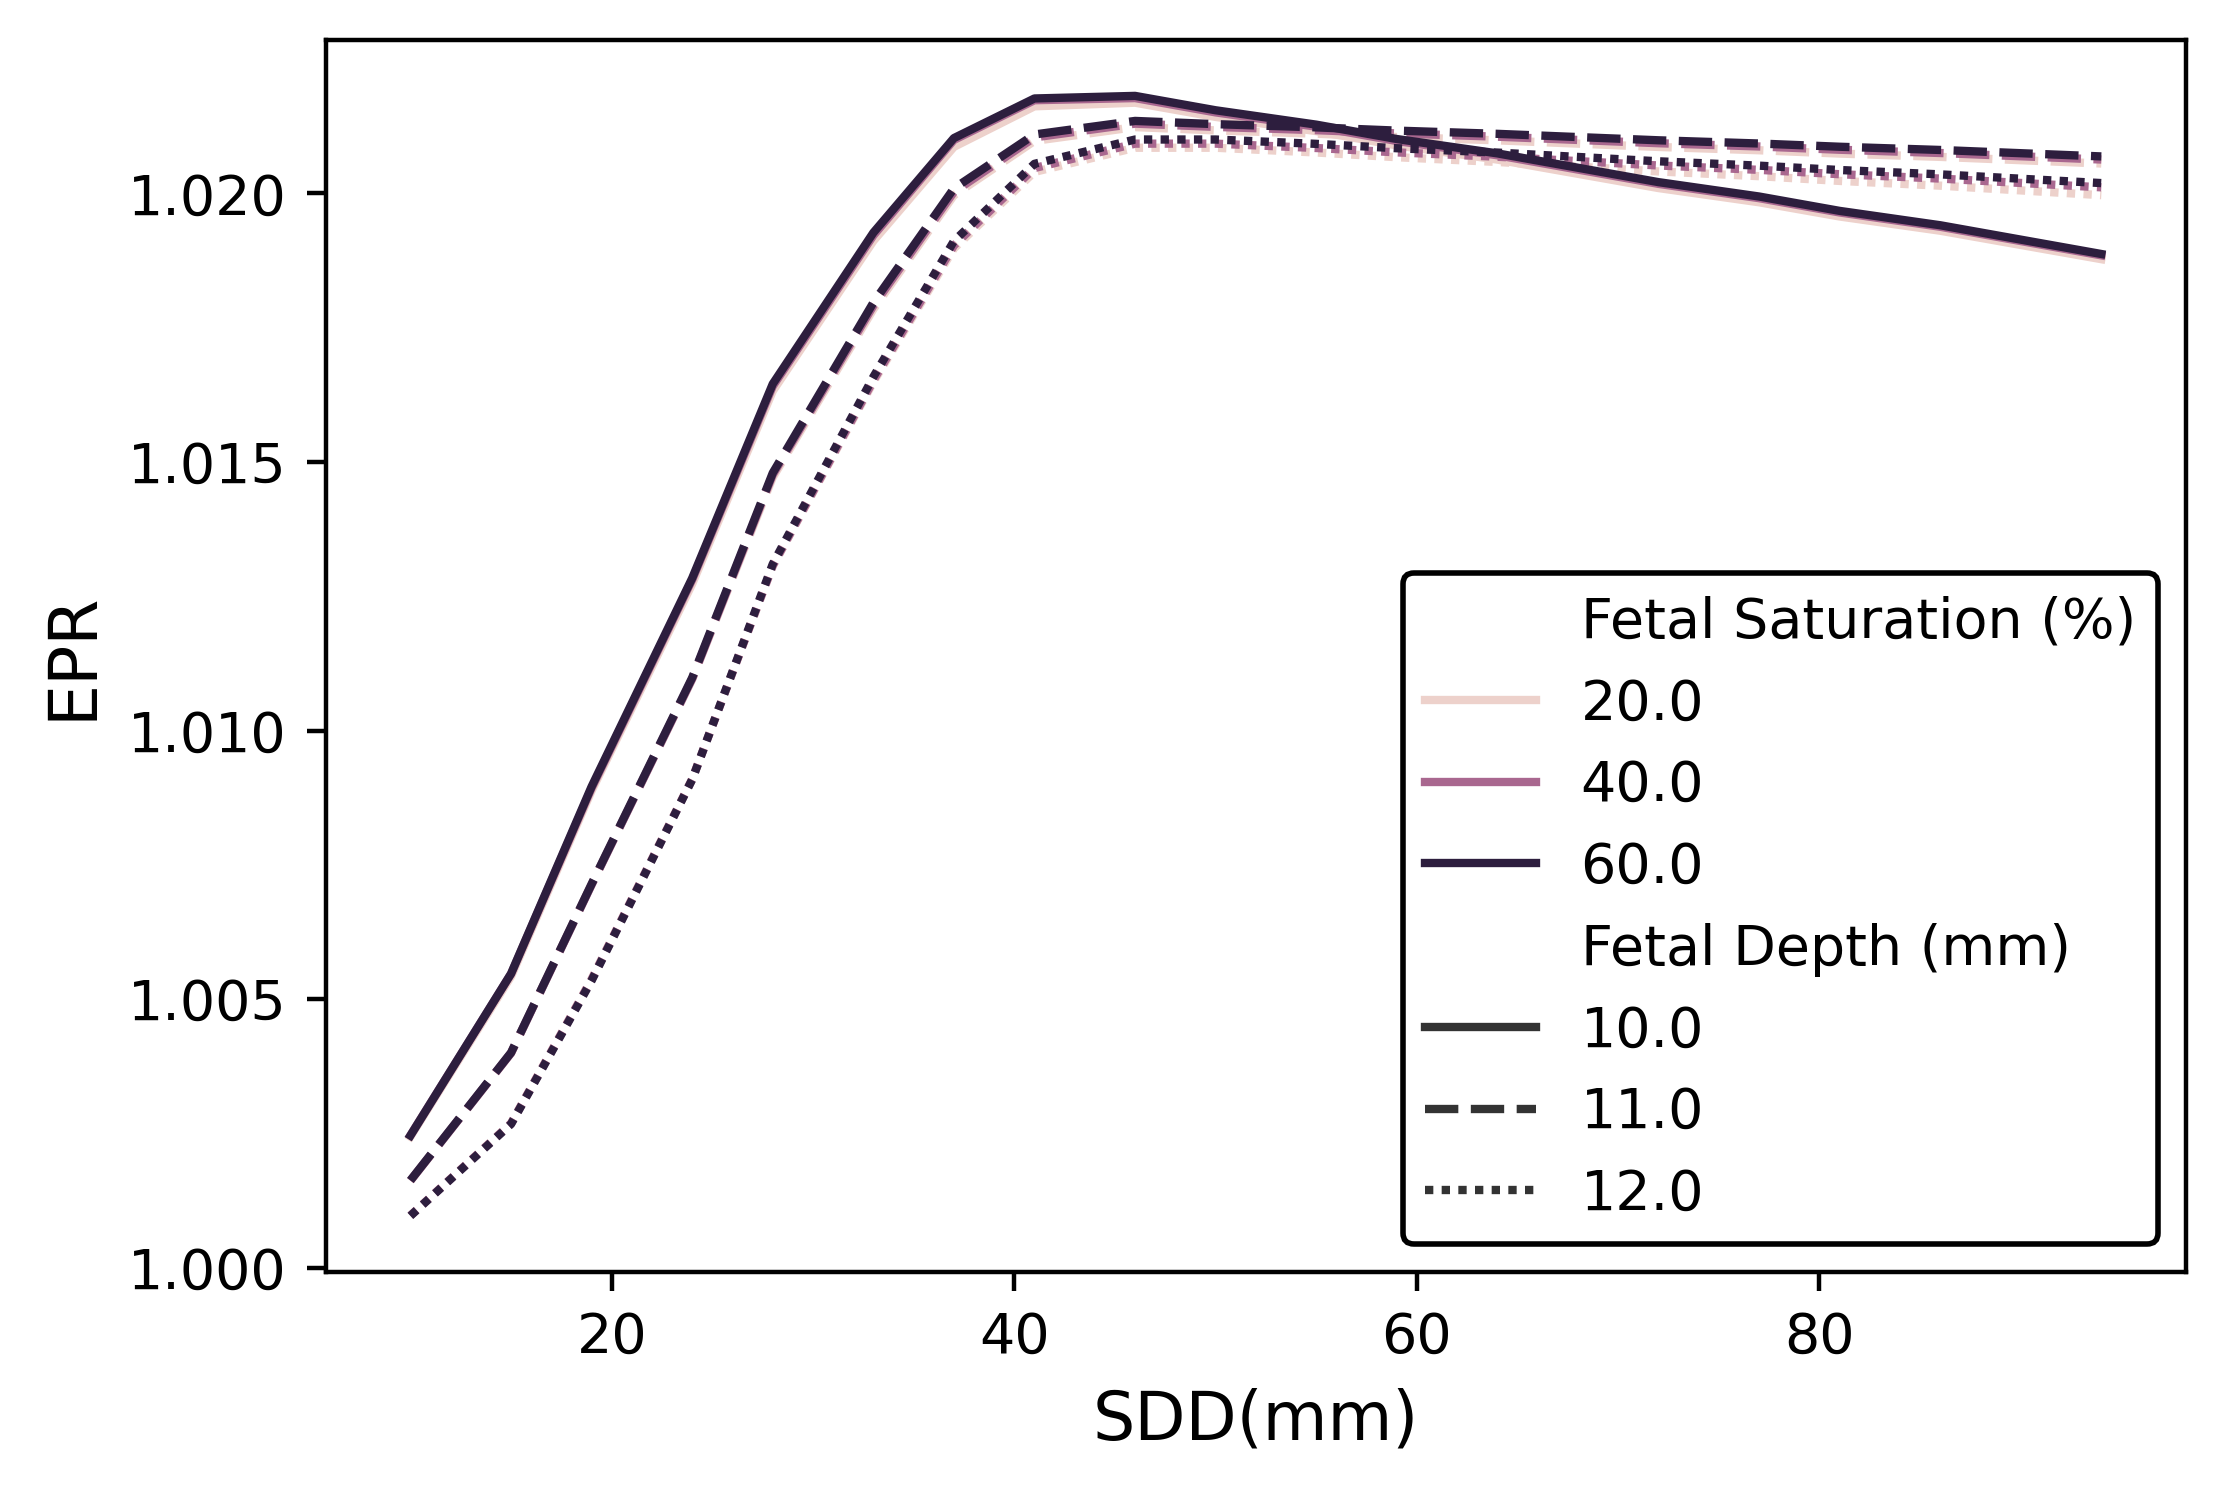

<Figure size 640x480 with 0 Axes>

In [24]:
fig = plt.figure(figsize=(6, 4), dpi=400)
sns.lineplot(pr_data1, x='SDD(mm)', y='PR', style='Fetal Depth (mm)', hue=r'Fetal Saturation (%)', markers=False)
plt.ylabel("EPR")
# Move the legend slightly upwards
plt.legend(loc='lower right', frameon=True, framealpha=1, edgecolor='black', facecolor='white')
plt.show()
plt.savefig("saved_figures/EPR_vs_SDD.svg")

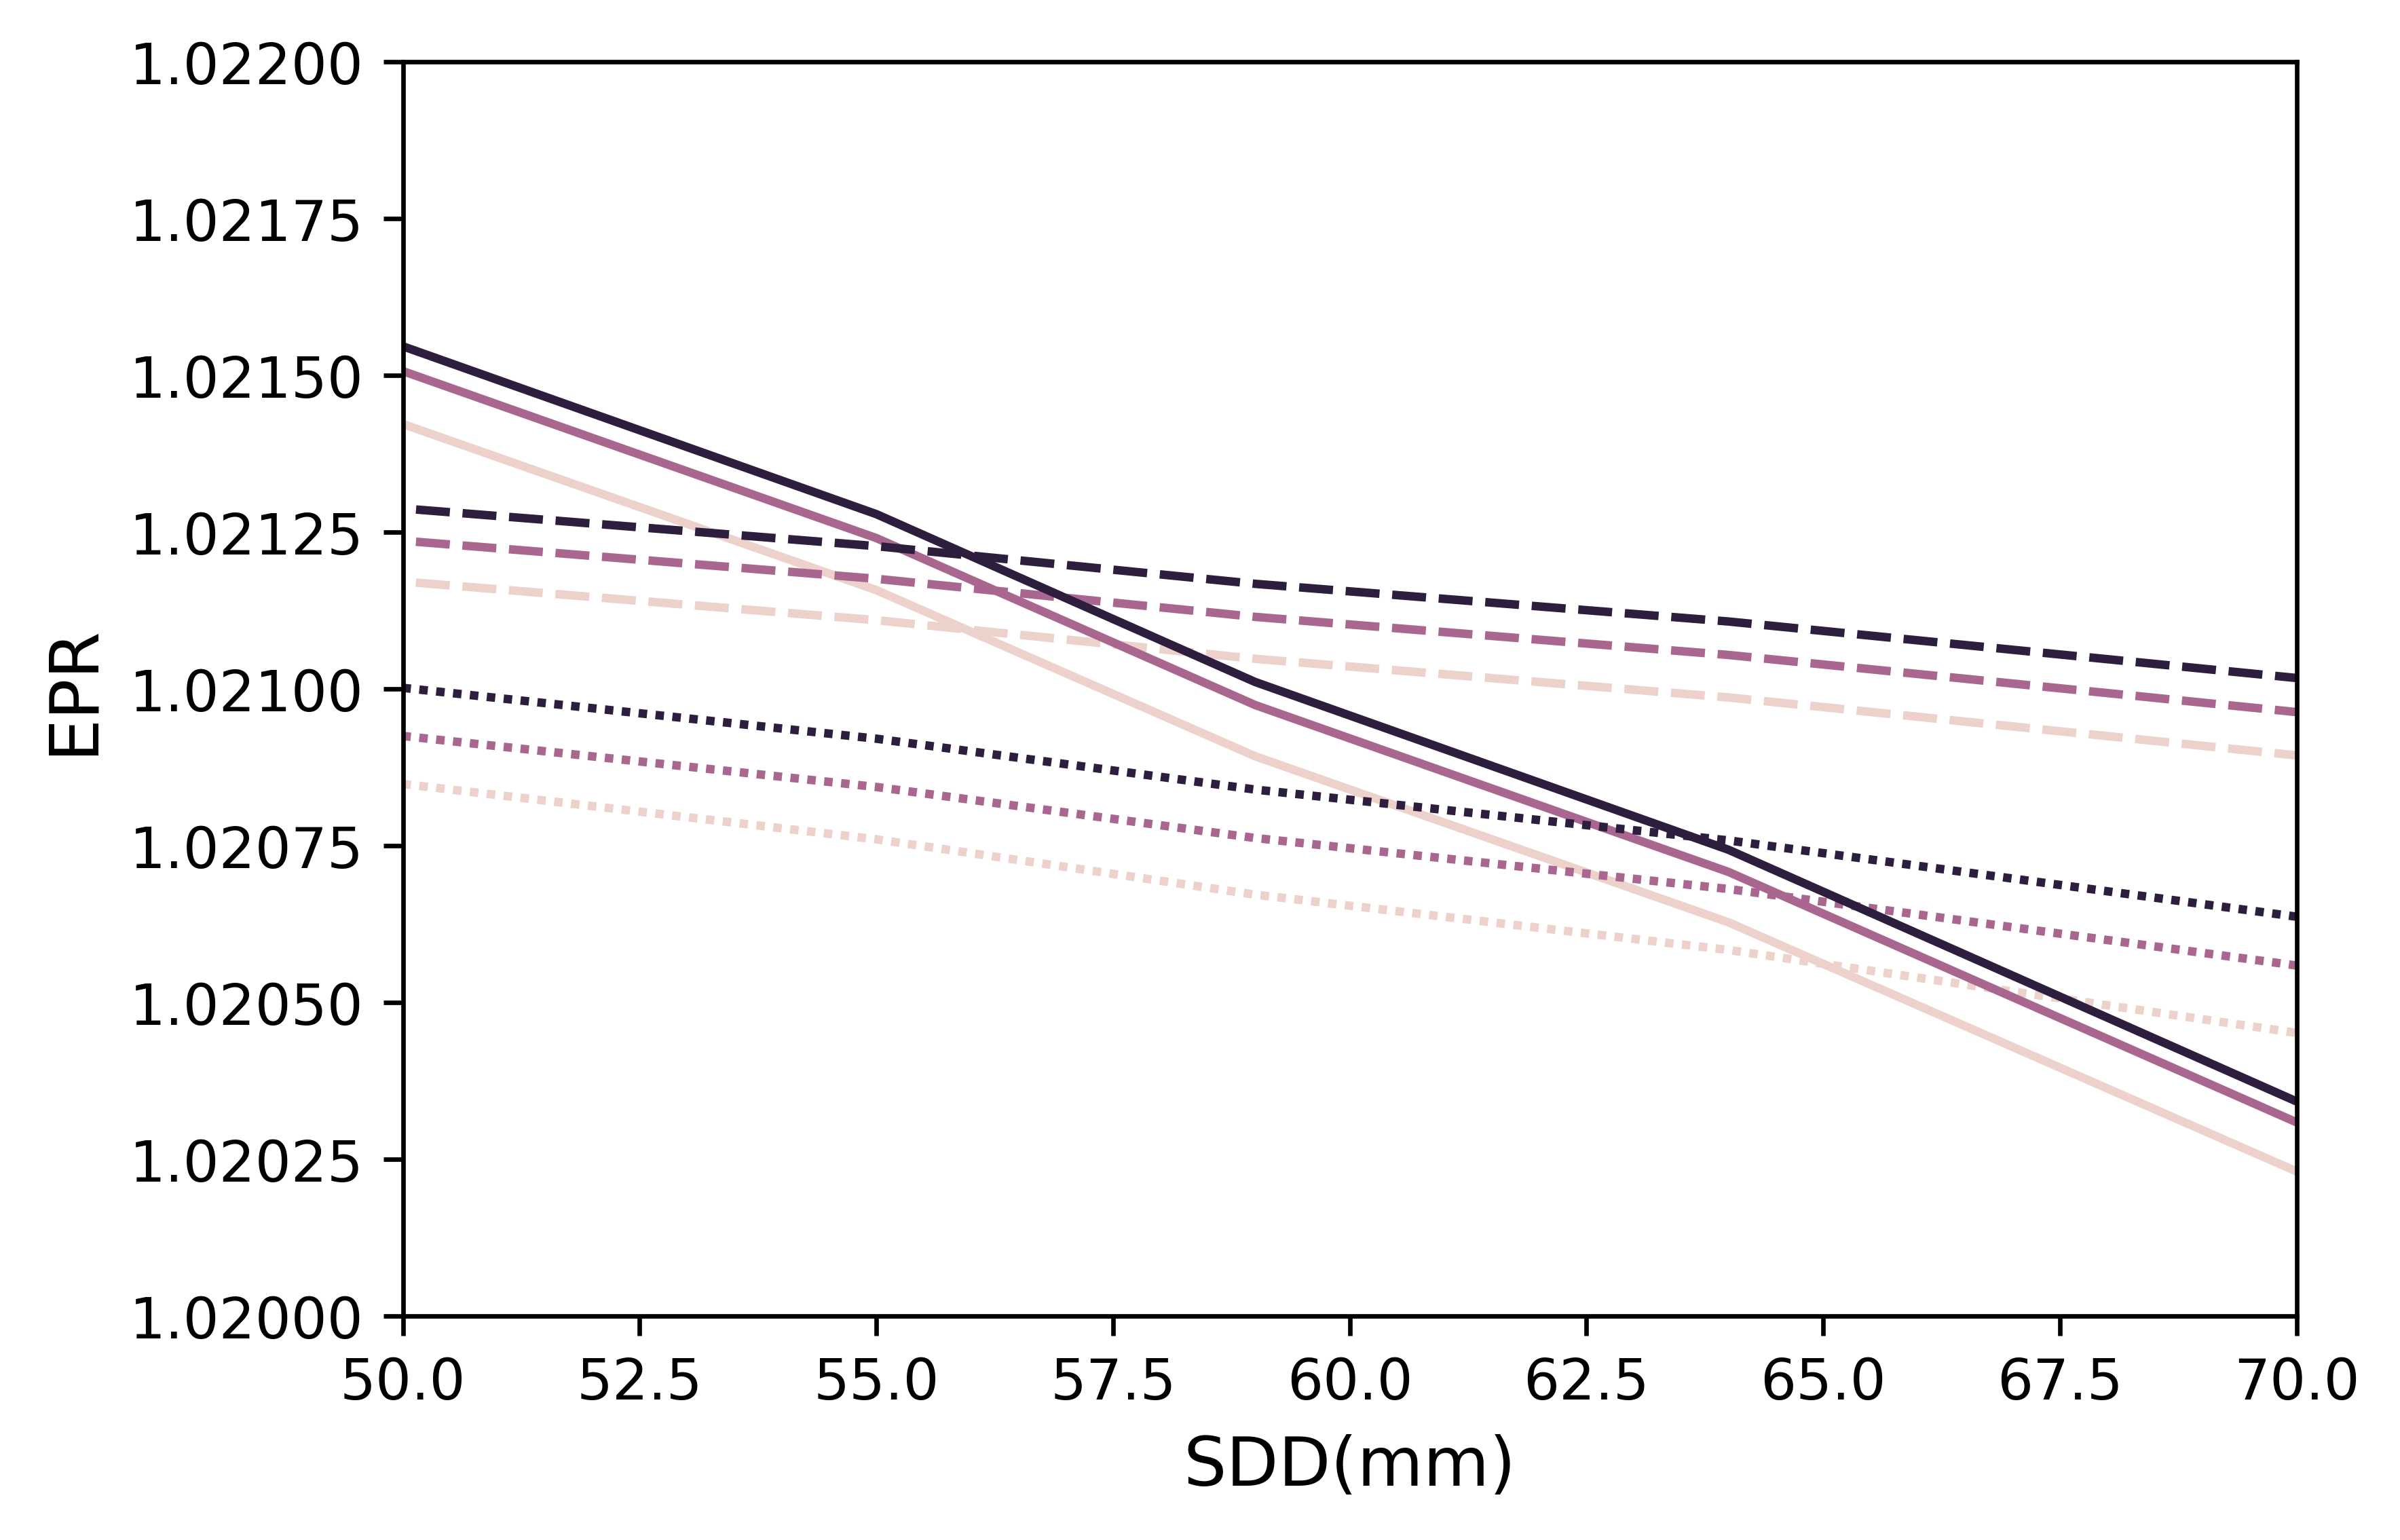

In [23]:
# Create a zooomed version of fig
fig = plt.figure(figsize=(6, 4), dpi=600)
sns.lineplot(pr_data1, x='SDD(mm)', y='PR', style='Fetal Depth (mm)', hue=r'Fetal Saturation (%)', legend=False)
plt.ylabel("EPR")
plt.xlim(50, 70)
plt.ylim(1.020, 1.022)
# plt.legend(loc='upper right', frameon=True, framealpha=1, edgecolor='black', facecolor='white')

plt.savefig("saved_figures/EPR_vs_SDD_zoomed.svg")